## Maximize risk-adjusted return
$$ max \quad w^T\mu - \gamma w^T \Sigma w $$
$$ s.t. \quad w^T1 = 1 $$
$$ w >= 0 $$
$ w $ = asset weights <br>
$ \Sigma $ = Covariance matrix <br>
$ \gamma \in [0,\infty) $ = risk-aversion parameter 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cvxpy as cp 
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [3]:
tickers = ['AAPL', 'INTC', 'IBM', 'MSFT']
data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True)
data.Close

[*********************100%***********************]  4 of 4 completed


,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-27,32.320957,135.802719,32.122070,59.957729
2017-02-28,32.335125,136.120651,31.849319,59.724361
2017-03-01,32.996033,137.733017,31.611776,60.620499
2017-03-02,32.800121,136.658096,31.594179,59.752361
2017-03-03,32.993668,136.294739,31.585375,59.976395
...,...,...,...,...
2022-02-18,167.300003,124.349998,45.040001,287.929993
2022-02-22,164.320007,123.919998,44.689999,287.720001
2022-02-23,160.070007,122.070000,44.650002,280.269989


In [4]:
returns = np.log(data.Close/data.Close.shift(1)).dropna()
returns

,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-28,0.000438,0.002338,-0.008527,-0.003900
2017-03-01,0.020233,0.011776,-0.007486,0.014893
2017-03-02,-0.005955,-0.007835,-0.000557,-0.014424
2017-03-03,0.005883,-0.002662,-0.000279,0.003742
2017-03-06,-0.003153,0.002330,-0.009235,0.000311
...,...,...,...,...
2022-02-18,-0.009400,-0.004974,-0.054651,-0.009678
2022-02-22,-0.017973,-0.003464,-0.007801,-0.000730
2022-02-23,-0.026205,-0.015042,-0.000895,-0.026234


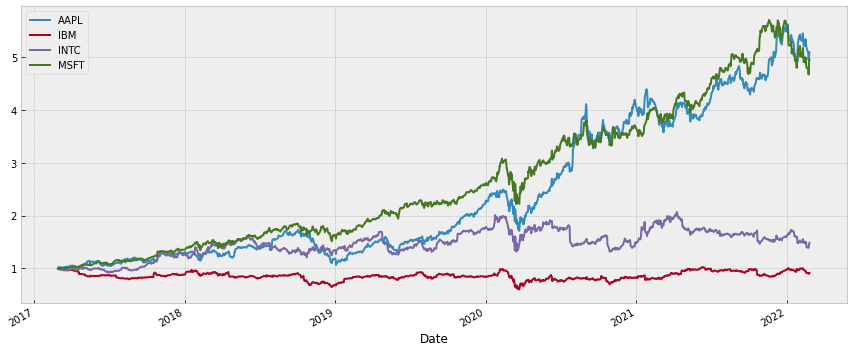

In [5]:
returns.cumsum().apply(np.exp).plot(figsize=(12,5))
plt.tight_layout()
plt.show()

In [6]:
avg_returns = returns.mean().values * 252
cov_mat = returns.cov().values * 252

In [7]:
weights = cp.Variable(len(tickers))
gamma = cp.Parameter(nonneg=True)
max_levarage = cp.Parameter()
portfolio_returns = avg_returns * weights
portfolio_volatility = cp.quad_form(weights, cov_mat)
obj_func = cp.Maximize(portfolio_returns - gamma * portfolio_volatility)
problem = cp.Problem(obj_func, 
                     [cp.sum(weights) == 1, 
                      cp.norm(weights,1) <= max_levarage])

In [8]:
n_points = 50
leverage_range = [i for i in range(1, 6)]
efficient_returns = np.zeros((len(leverage_range), n_points))
efficient_volatility = np.zeros((len(leverage_range), n_points))
efficient_weights = np.zeros((len(leverage_range), n_points, len(tickers)))
gamma_range = np.logspace(-3, 3, num=n_points)

for i in tqdm(range(len(leverage_range)), leave=False):
    for j in tqdm(range(n_points), leave=False):
        max_levarage.value = leverage_range[i]
        gamma.value = gamma_range[j]
        problem.solve()
        efficient_volatility[i, j] = cp.sqrt(portfolio_volatility).value
        efficient_returns[i, j] = portfolio_returns.value
        efficient_weights[i, j, :] = weights.value 
        
sharpe_ratios = efficient_returns / efficient_volatility

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

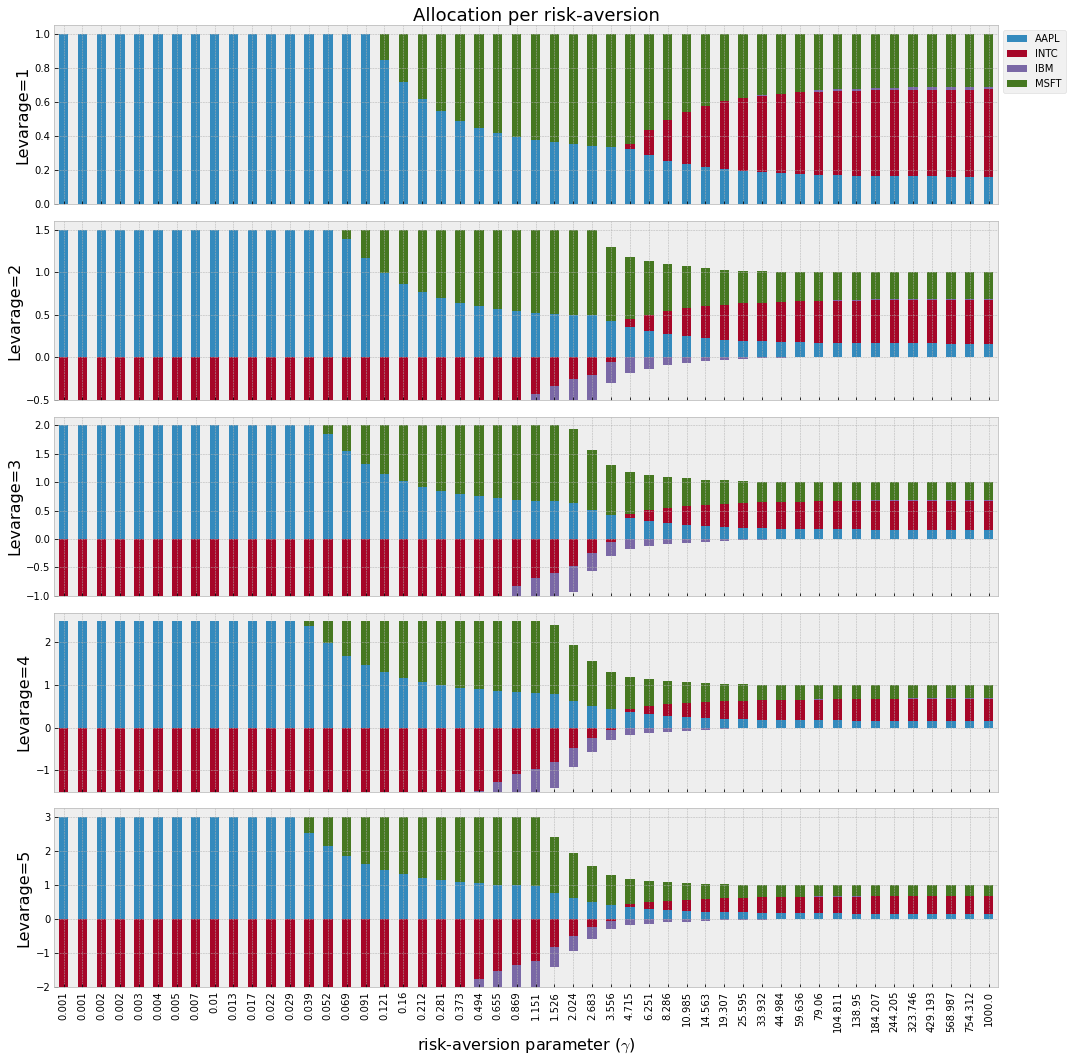

In [9]:
fig, ax = plt.subplots(len(leverage_range), 1, figsize=(15,15), sharex=True)

for i in range(len(leverage_range)):
    w_df = pd.DataFrame(data=np.round(efficient_weights[i],5), 
                        index=np.round(gamma_range,3), columns=tickers)
    w_df.plot(kind='bar', stacked=True, ax=ax[i], legend=False)
    ax[i].set_ylabel(f'Levarage={leverage_range[i]}', fontsize=16)
    
ax[0].legend(bbox_to_anchor=(1,1))
plt.xlabel('risk-aversion parameter ($\gamma$)', fontsize=16)
plt.suptitle('Allocation per risk-aversion', fontsize=18)

plt.tight_layout()
plt.show()

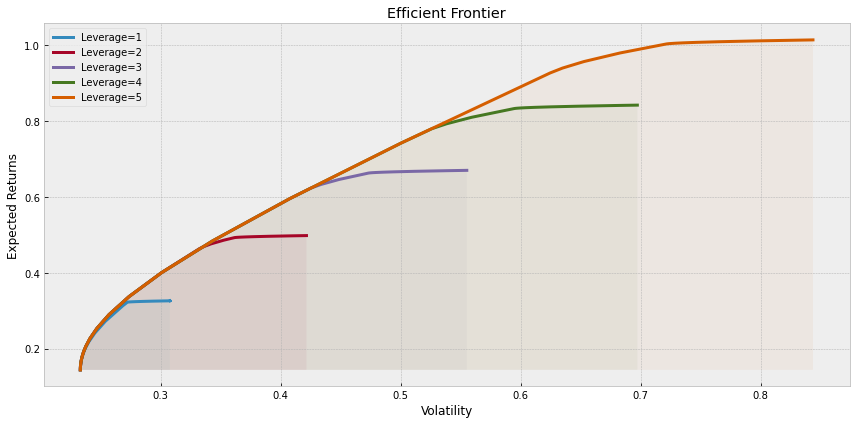

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(leverage_range)):
    ax.plot(efficient_volatility[i], efficient_returns[i], 
            linewidth=3, label=f'Leverage={leverage_range[i]}')
    ax.fill_between(x=efficient_volatility[i],
                    y1=efficient_returns[i], 
                    y2=efficient_returns[i].min(),
                    alpha=0.05)

ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected Returns')
ax.legend()
plt.tight_layout()
plt.show()